In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import psycopg2
import scipy.stats.stats as stats
import scorecardpy as sc 
import re
import traceback

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

## Get the dataset

In [ ]:
# Create the connector to the database
conn = psycopg2.connect(
    database="hacketon_fraud",
    user="ramamuharam",
    host="localhost",
    port=5432
)

# Query for the datamart
sql_query = """
WITH uf AS (
	SELECT
	    u.user_id,
	    u.name,
	    u.email,
	    u.phone,
	    u.registration_date,
	    u.job_title,
	    u.user_type,
	    u.kyc_status,
	    u.is_fraud, -- ini bisa dipakai sebagai label supervised
	    -- Transaction behavior
	    COUNT(t.transaction_id) AS total_transactions,
	    SUM(t.amount) AS total_amount,
	    AVG(t.amount) AS avg_transaction_amount,
	    MAX(t.amount) AS max_transaction_amount,
	    MIN(t.amount) AS min_transaction_amount,
	    COUNT(DISTINCT t.merchant_id) AS unique_merchants,
	    COUNT(DISTINCT t.bank_id) AS unique_banks,
	    SUM(CASE WHEN t.is_fraud THEN 1 ELSE 0 END) AS fraud_transaction_count,
	    -- Device behavior
	    COUNT(DISTINCT d.device_id) AS total_devices,
	    COUNT(DISTINCT dul.ip_address) AS unique_ip_count,
	    SUM(CASE WHEN d.is_emulator THEN 1 ELSE 0 END) AS emulator_device_count,
	    -- IP Address anomaly
	    SUM(CASE WHEN ip.is_proxy THEN 1 ELSE 0 END) AS proxy_ip_count,    
	    -- Alert pattern
	    COUNT(a.alert_id) AS alert_count,
	    AVG(a.score) AS avg_alert_score,  
	    -- Compliance
	    COUNT(cr.record_id) AS compliance_record_count
	FROM users u
	LEFT JOIN transactions t ON u.user_id = t.user_id
	LEFT JOIN devices d ON u.user_id = d.user_id
	LEFT JOIN device_usage_logs dul ON u.user_id = dul.user_id AND d.device_id = dul.device_id
	LEFT JOIN ip_addresses ip ON u.user_id = ip.user_id
	LEFT JOIN alerts a ON u.user_id = a.user_id
	LEFT JOIN compliance_records cr ON u.user_id = cr.user_id
	GROUP BY
	    u.user_id, u.name, u.email, u.phone, u.registration_date,
	    u.job_title, u.user_type, u.kyc_status, u.is_fraud
)
SELECT *
	, CASE
	    WHEN 
	        uf.total_transactions > 50 AND uf.avg_transaction_amount < 10000
	        OR uf.emulator_device_count >= 2
	        OR uf.proxy_ip_count >= 3
	        OR uf.alert_count >= 3 AND uf.avg_alert_score > 70
	        OR uf.unique_merchants >= 10 AND uf.total_transactions > 20
	        OR uf.compliance_record_count >= 2
	    THEN 1 ELSE 0
	END AS transaction_is_fraud_flag
FROM uf
;
"""

# Create the data frame from the query
df = pd.read_sql_query(sql=sql_query, con=conn)
df_copy = df.copy()
df.head()


## Data Preprocessing

### Handling Missing Values

In [ ]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(10)

Only 4 columns have missing values and all of them are numeric. We can say that the absence of values meaning there is no transaction happening there. So we can fill the missing values with `0`.

The `avg_alert_score` have no non-missing values so we can drop the column.

In [ ]:
# Fill the missing values with 0
for column in ['max_transaction_amount', 'total_amount', 'avg_transaction_amount', 'min_transaction_amount']:
    df[column] = df[column].fillna(0)
   
# Drop avg_alert_score column    
df.drop("avg_alert_score", axis=1, inplace=True)
   
# Check if there's still any missing values left    
df[['max_transaction_amount', 'total_amount', 'avg_transaction_amount', 'min_transaction_amount']].isnull().sum()

## Exploratory Data Analysis

The goal is to understand the data and dependency between independent variable and target variable, and as a guide to feature selection and model deployment. It includes:

- Univariate Analysis: Distribution of each individual feature.
- Bivariate Analysis: Relationship between feature and target variable.
- Correlation Matrix (Heatmap): Analyze relationship between numerical features.

### Transaction Fraud Ratio

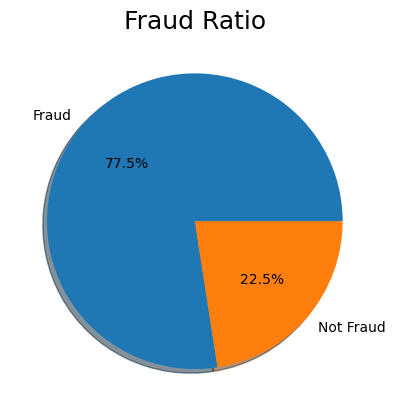

In [317]:
plt.figure()
plt.pie(df.transaction_is_fraud_flag.value_counts(), labels=['Fraud', 'Not Fraud'], autopct='%1.1f%%', shadow=True)
plt.title('Fraud Ratio', fontsize=18)
plt.show()

The dataset is quite imbalanced with 77.5% have fraud flag and 22.5% don't.

### Distribution of Numeric Columns

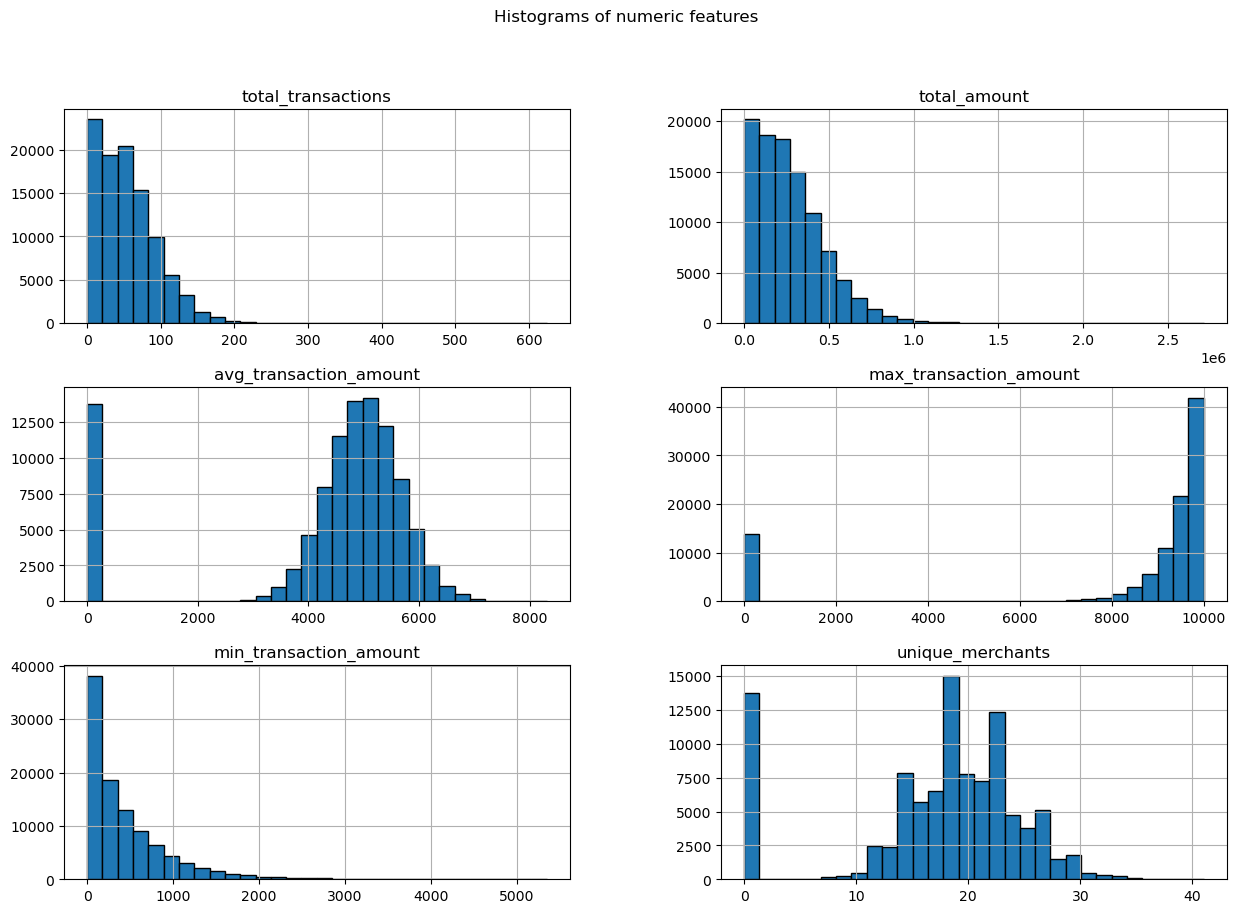

In [318]:
num_cols = ['total_transactions','total_amount','avg_transaction_amount',
            'max_transaction_amount','min_transaction_amount', 
            'unique_merchants']
df[num_cols].hist(figsize=(15,10), bins=30, edgecolor='k')
plt.suptitle("Histograms of numeric features")
plt.show()

### Distribution of Categorical Columns

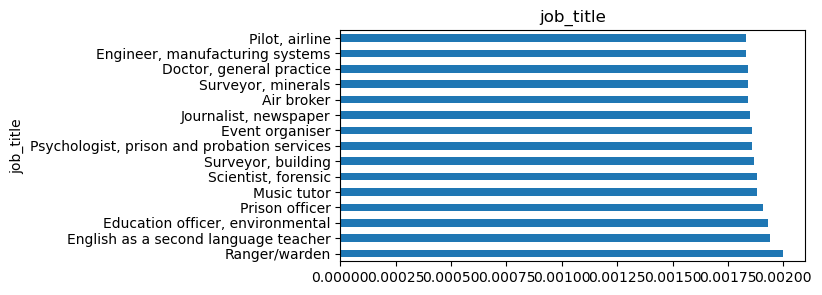

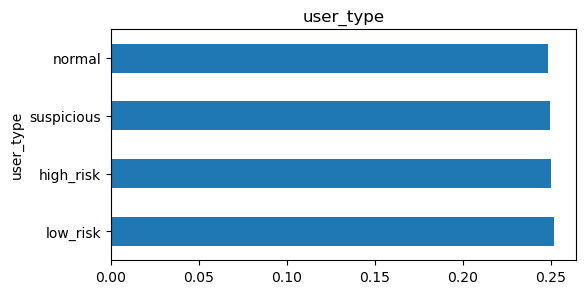

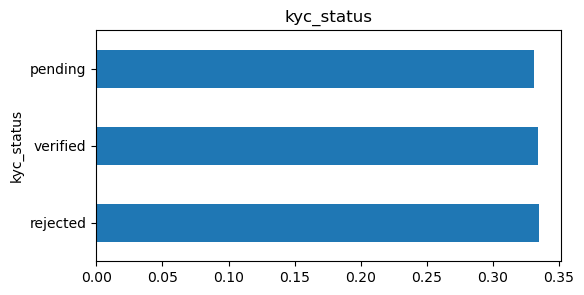

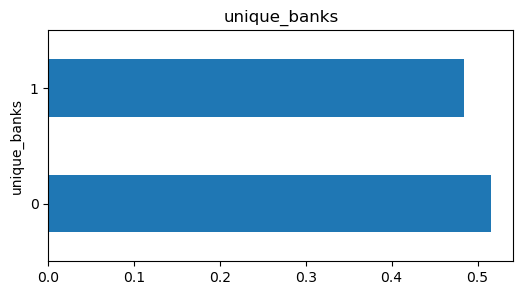

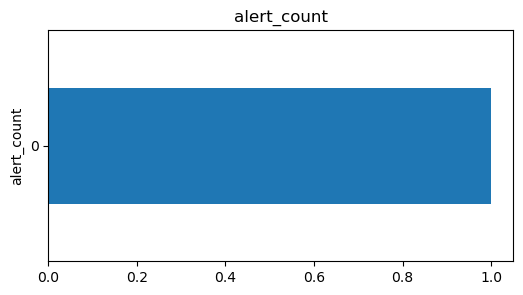

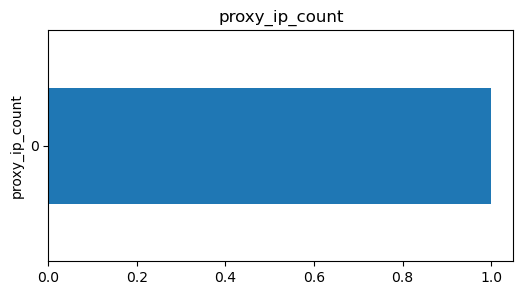

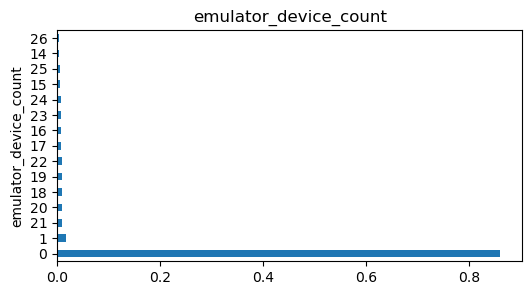

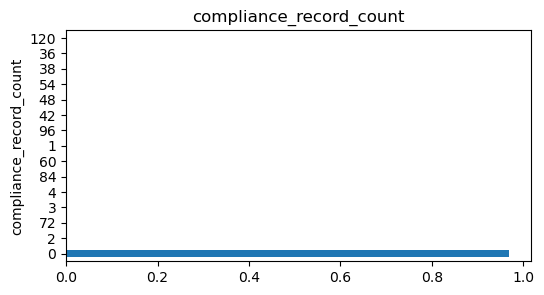

In [319]:
cat_cols = ['job_title','user_type','kyc_status', 'unique_banks', 'alert_count',
            'proxy_ip_count', 'emulator_device_count', 'compliance_record_count']
for c in cat_cols:
    df[c].value_counts(normalize=True)[:15].plot.barh(figsize=(6,3))
    plt.title(c)
    plt.show()

### Relationship between Feature and Target Variable

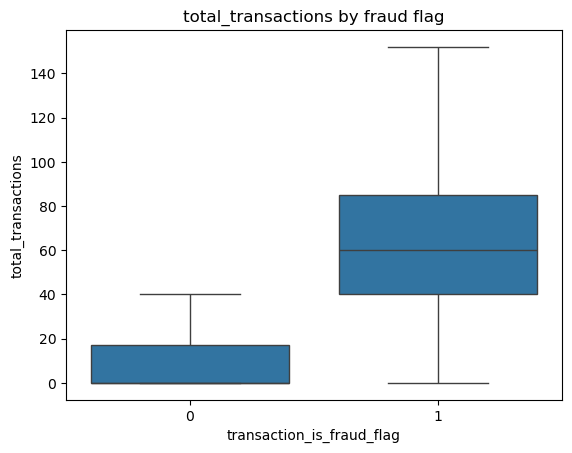

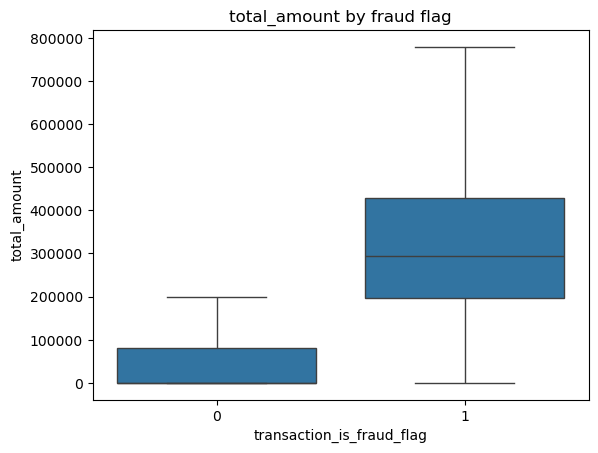

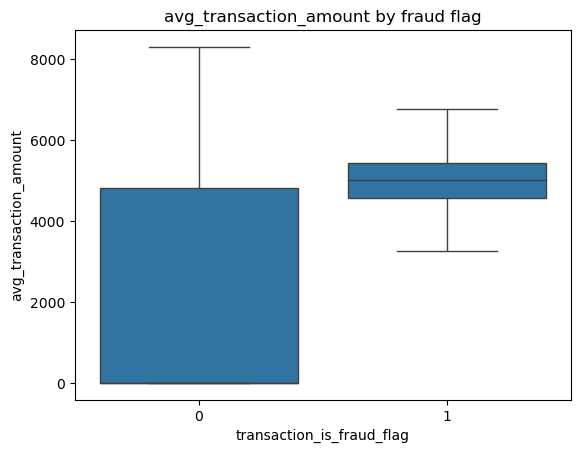

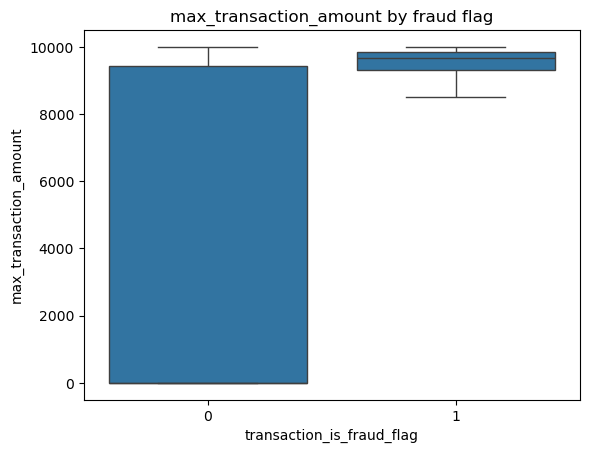

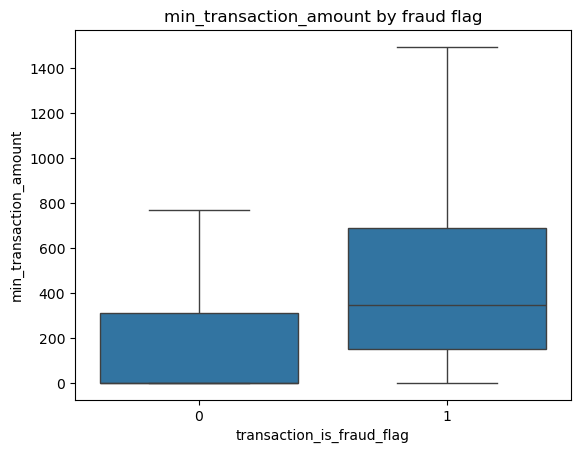

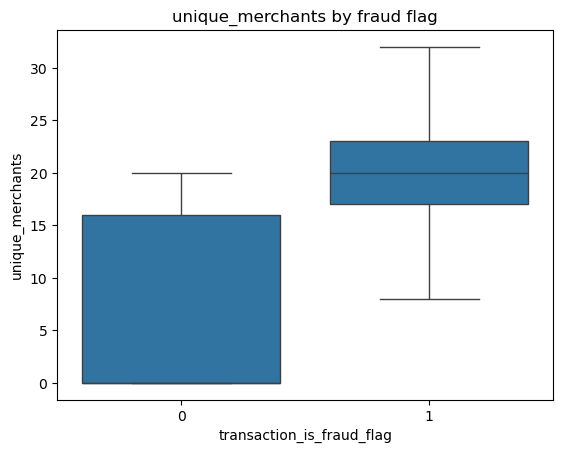

In [320]:
import seaborn as sns

for col in num_cols:
    sns.boxplot(x='transaction_is_fraud_flag', y=col, data=df, showfliers=False)
    plt.title(f"{col} by fraud flag"); plt.show()

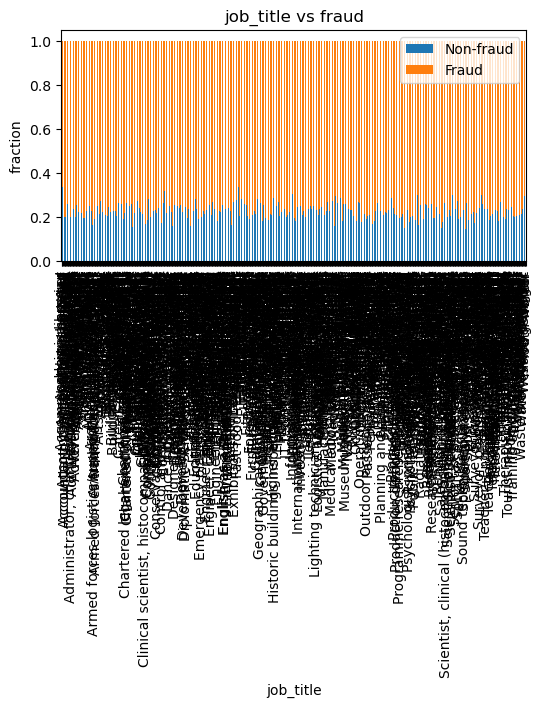

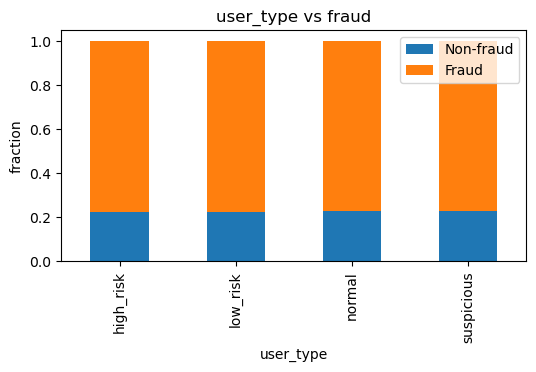

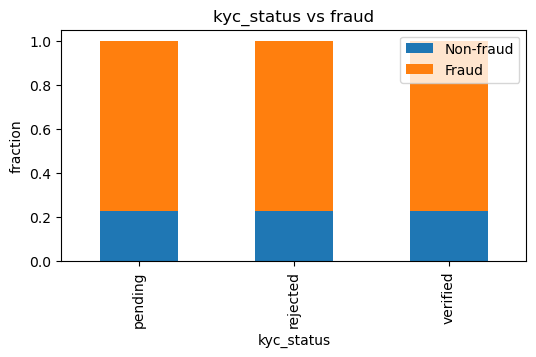

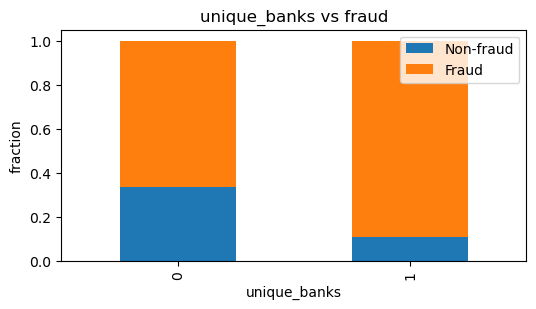

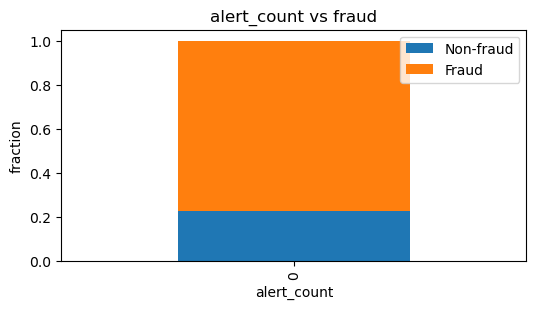

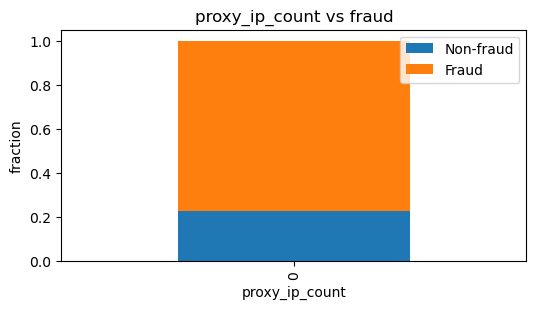

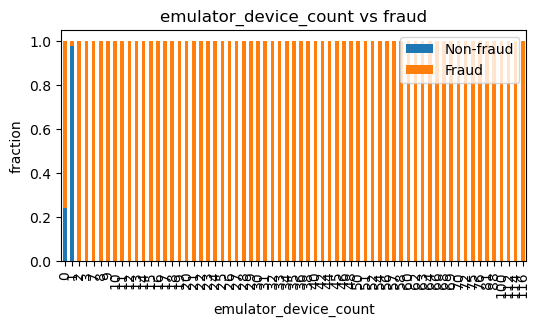

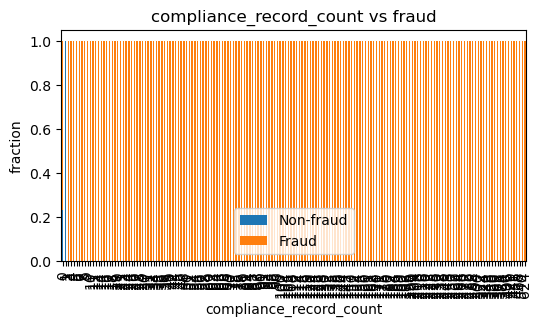

In [321]:
for c in cat_cols:
    ct = pd.crosstab(df[c], df['transaction_is_fraud_flag'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(6,3))
    plt.title(f"{c} vs fraud"); plt.ylabel("fraction"); plt.legend(["Non-fraud","Fraud"])
    plt.show()

### Correlation Matrix

Text(0.5, 1.0, 'Spearman correlation')

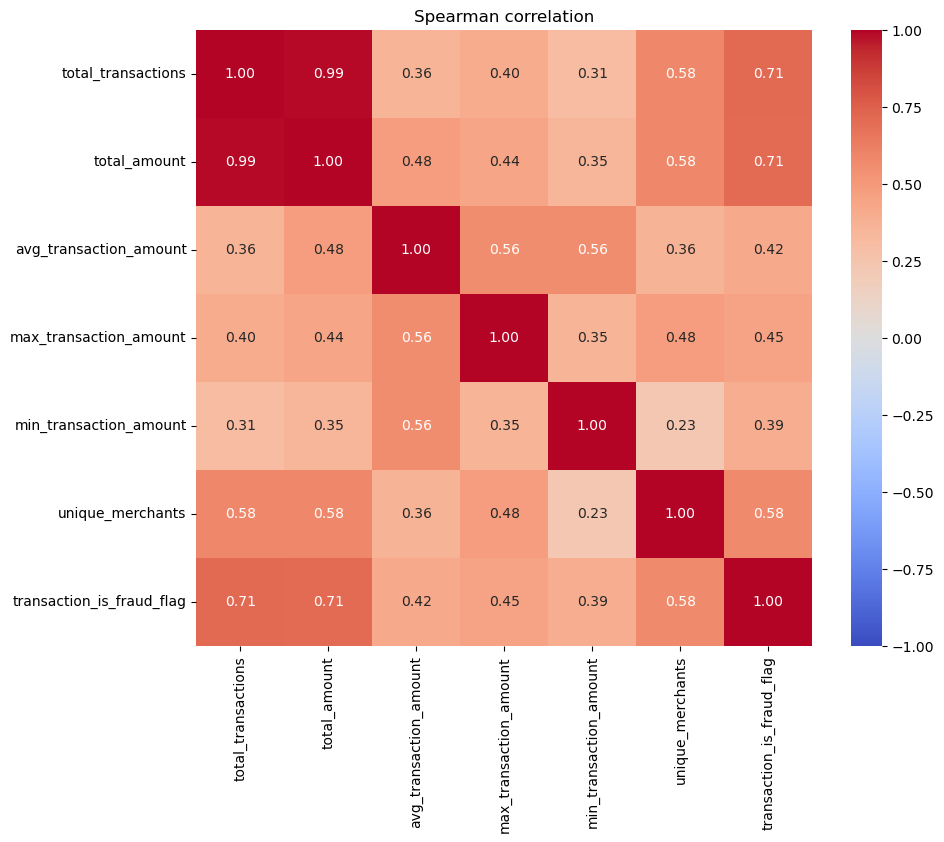

In [322]:
corr = df[num_cols + ['transaction_is_fraud_flag']].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f",
            vmin=-1, vmax=1, square=True)
plt.title("Spearman correlation")

## Data Processing

### Drop columns which have IV < 0.02

In [323]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        # bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [324]:
import numpy as np
import pandas as pd
from scipy import stats
import re, traceback

# ──────────────────────────────────────────────────────────────
max_bin  = 20
force_bin = 3
# ──────────────────────────────────────────────────────────────
def mono_bin(Y, X, n=max_bin):
    """Monotonic binning + IV/WOE table for a numeric variable."""
    df  = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df[df.X.isnull()]
    notmiss  = df[df.X.notnull()]

    r = 0
    while abs(r) < 1 and n > 1:                    # shrink until monotonic
        try:
            tmp = pd.DataFrame({
                "X": notmiss.X,
                "Y": notmiss.Y,
                "Bucket": pd.qcut(notmiss.X, n, duplicates="drop")
            })
            grp = tmp.groupby("Bucket", as_index=True)
            r, _ = stats.spearmanr(grp.mean().X, grp.mean().Y)
            n -= 1
        except ValueError:                         # too many duplicate edges
            n -= 1

    # force equal-width bins if only one bucket left
    if len(grp) == 1:
        n    = force_bin
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:              # all values identical
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1] - bins[1] / 2
        tmp = pd.DataFrame({
            "X": notmiss.X,
            "Y": notmiss.Y,
            "Bucket": pd.cut(notmiss.X,
                             np.unique(bins),
                             include_lowest=True)
        })
        grp = tmp.groupby("Bucket", as_index=True)

    # aggregate
    tbl = pd.DataFrame({
        "MIN_VALUE":   grp.min().X,
        "MAX_VALUE":   grp.max().X,
        "COUNT":       grp.size(),
        "EVENT":       grp.sum().Y
    })
    tbl["NONEVENT"] = tbl["COUNT"] - tbl["EVENT"]
    tbl.reset_index(drop=True, inplace=True)

    # add missing-value row if necessary
    if not justmiss.empty:
        missing_row = pd.DataFrame({
            "MIN_VALUE":  [np.nan],
            "MAX_VALUE":  [np.nan],
            "COUNT":      [justmiss.Y.count()],
            "EVENT":      [justmiss.Y.sum()],
            "NONEVENT":   [justmiss.Y.count() - justmiss.Y.sum()]
        })
        tbl = pd.concat([tbl, missing_row], ignore_index=True)

    _dist_event      = tbl.EVENT     / tbl.EVENT.sum()
    _dist_nonevent   = tbl.NONEVENT  / tbl.NONEVENT.sum()
    tbl["EVENT_RATE"]      = tbl.EVENT     / tbl.COUNT
    tbl["NON_EVENT_RATE"]  = tbl.NONEVENT  / tbl.COUNT
    tbl["DIST_EVENT"]      = _dist_event
    tbl["DIST_NON_EVENT"]  = _dist_nonevent
    tbl["WOE"]             = np.log(_dist_event / _dist_nonevent).replace([np.inf, -np.inf], 0)
    tbl["IV"]              = (_dist_event - _dist_nonevent) * tbl.WOE
    tbl["VAR_NAME"]        = "VAR"
    tbl = tbl[["VAR_NAME","MIN_VALUE","MAX_VALUE","COUNT","EVENT",
               "EVENT_RATE","NONEVENT","NON_EVENT_RATE",
               "DIST_EVENT","DIST_NON_EVENT","WOE","IV"]]
    tbl["IV"] = tbl.IV.sum()           # same IV for every row

    return tbl
# ──────────────────────────────────────────────────────────────
def char_bin(Y, X):
    """WOE/IV table for a categorical variable."""
    df  = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df[df.X.isnull()]
    notmiss  = df[df.X.notnull()]

    grp = notmiss.groupby("X", as_index=True)
    tbl = pd.DataFrame({
        "MIN_VALUE": grp.sum().index,   # category label
        "MAX_VALUE": grp.sum().index,
        "COUNT":     grp.size(),
        "EVENT":     grp.sum().Y
    })
    tbl["NONEVENT"] = tbl["COUNT"] - tbl["EVENT"]

    if not justmiss.empty:
        missing_row = pd.DataFrame({
            "MIN_VALUE": [np.nan],
            "MAX_VALUE": [np.nan],
            "COUNT":     [justmiss.Y.count()],
            "EVENT":     [justmiss.Y.sum()],
            "NONEVENT":  [justmiss.Y.count() - justmiss.Y.sum()]
        })
        tbl = pd.concat([tbl, missing_row], ignore_index=True)

    _dist_event     = tbl.EVENT    / tbl.EVENT.sum()
    _dist_nonevent  = tbl.NONEVENT / tbl.NONEVENT.sum()

    tbl["EVENT_RATE"]      = tbl.EVENT    / tbl.COUNT
    tbl["NON_EVENT_RATE"]  = tbl.NONEVENT / tbl.COUNT
    tbl["DIST_EVENT"]      = _dist_event
    tbl["DIST_NON_EVENT"]  = _dist_nonevent
    tbl["WOE"]             = np.log(_dist_event / _dist_nonevent).replace([np.inf,-np.inf],0)
    tbl["IV"]              = (_dist_event - _dist_nonevent) * tbl.WOE
    tbl["VAR_NAME"]        = "VAR"
    tbl = tbl[["VAR_NAME","MIN_VALUE","MAX_VALUE","COUNT","EVENT",
               "EVENT_RATE","NONEVENT","NON_EVENT_RATE",
               "DIST_EVENT","DIST_NON_EVENT","WOE","IV"]]
    tbl["IV"] = tbl.IV.sum()
    tbl.reset_index(drop=True, inplace=True)

    return tbl
# ──────────────────────────────────────────────────────────────
def data_vars(df, target):
    """
    Loop through all columns in `df`, calculate IV/WOE tables,
    and return the concatenated detail table + summary IV table.
    """
    iv_tables   = []             # collect per-variable tables
    numeric_iv  = []

    for col in df.columns:
        if col.upper() == target.name.upper():
            continue

        if np.issubdtype(df[col].dtype, np.number) and df[col].nunique() > 2:
            conv = mono_bin(target, df[col])
        else:
            conv = char_bin(target, df[col])

        conv["VAR_NAME"] = col
        iv_tables.append(conv)
        numeric_iv.append({"VAR_NAME": col, "IV": conv.IV.iloc[0]})

    iv_df = pd.concat(iv_tables, ignore_index=True)
    iv_summary = pd.DataFrame(numeric_iv)

    return iv_df, iv_summary

In [ ]:
# Choose target and predictor set
target_col   = "transaction_is_fraud_flag"
feature_cols = df.columns.drop(
    ["user_id", "name", "email", "phone", "registration_date", target_col]
)

iv_detail, iv_summary = data_vars(df[feature_cols], df[target_col])
iv_summary.sort_values("IV", ascending=True, inplace=True)
iv_summary

In [326]:
low_iv_vars = iv_summary.loc[iv_summary["IV"] < 0.04, "VAR_NAME"]
print("Dropping", len(low_iv_vars), "low-IV variables:", low_iv_vars.tolist())

# Drop columns with low IV
df = df.drop(columns=low_iv_vars)

# Also drop columns that are irrelevant to do the modelling
df = df.drop(columns=["user_id", "name", "email", "phone", "registration_date"])

Dropping 9 low-IV variables: ['is_fraud', 'proxy_ip_count', 'alert_count', 'kyc_status', 'user_type', 'compliance_record_count', 'unique_ip_count', 'emulator_device_count', 'job_title']


In [327]:
df.head()

,total_transactions,total_amount,avg_transaction_amount,max_transaction_amount,min_transaction_amount,unique_merchants,unique_banks,fraud_transaction_count,total_devices,transaction_is_fraud_flag
0,72,352197.44,4891.631111,9787.61,707.20,18,0,4,4,1
1,105,473650.55,4510.957619,9951.57,32.71,21,0,0,5,1
2,120,599040.78,4992.006500,9863.45,2058.64,20,1,12,6,1
3,48,215105.30,4481.360417,9709.38,312.60,24,1,8,2,1
4,42,207242.94,4934.355714,9084.11,546.76,21,1,6,2,1


### WOE Binning

The `scorecardpy` package is commonly used for calculate credit risk scorecard: https://pypi.org/project/scorecardpy/

In [ ]:
bins = sc.woebin(dt=df, y='transaction_is_fraud_flag')
# bins

In [ ]:
# breaking df into train and test
train, test = sc.split_df(df, 'transaction_is_fraud_flag').values()

# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
X_train = train_woe.loc[:,train_woe.columns != 'transaction_is_fraud_flag']
y_train = train_woe.loc[:,'transaction_is_fraud_flag']
y_test = test_woe.loc[:,'transaction_is_fraud_flag']
X_test = test_woe.loc[:,train_woe.columns != 'transaction_is_fraud_flag']

### Data Imbalanced Handling

In [331]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def smote_sklearn(X, y, k_neighbors=5, sampling_ratio=1.0, random_state=42):
    """
    A minimal SMOTE implementation:
    - X: 2D array or DataFrame of features
    - y: 1D array or Series of 0/1 labels
    - sampling_ratio: fraction of (n_majority - n_minority) to generate
    """
    # to numpy
    X = np.asarray(X)
    y = np.asarray(y)
    rng = np.random.RandomState(random_state)

    # separate classes
    X_min = X[y == 1]
    X_maj = X[y == 0]
    n_min, n_features = X_min.shape
    n_maj = X_maj.shape[0]
    n_new = int((n_maj - n_min) * sampling_ratio)

    # fit k-NN on minority
    neigh = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_min)
    # each row’s neighbors (including itself at index 0)
    nbrs = neigh.kneighbors(X_min, return_distance=False)[:, 1:]  

    # generate synthetic points
    X_new = np.zeros((n_new, n_features))
    for i in range(n_new):
        idx = rng.randint(0, n_min)
        nn  = rng.choice(nbrs[idx])
        diff = X_min[nn] - X_min[idx]
        gap  = rng.rand()
        X_new[i] = X_min[idx] + gap * diff

    # labels for synthetic
    y_new = np.ones(n_new, dtype=int)

    # stack and return
    X_res = np.vstack([X, X_new])
    y_res = np.concatenate([y, y_new])

    return X_res, y_res

In [332]:
# X_train, y_train = smote_sklearn(X_train, y_train, k_neighbors=5, sampling_ratio=1.0)

In [333]:
# y_train.value_counts(normalize=True)

## Using Logistic Regression from WoE data

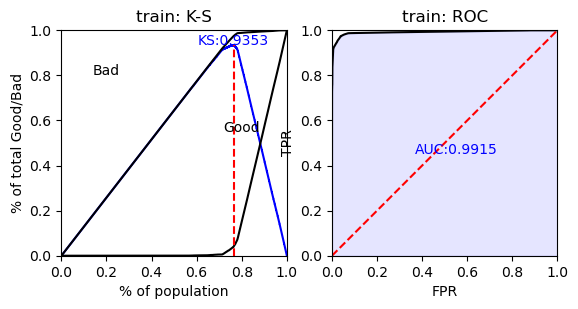

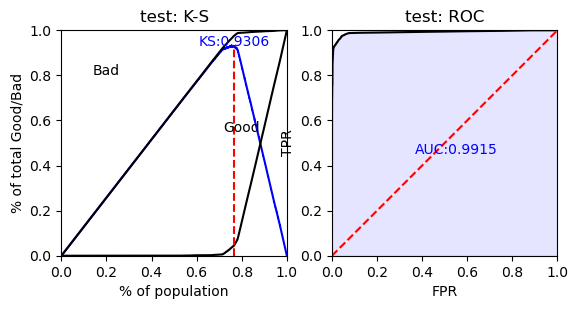

/Users/ramamuharam/miniforge3/envs/hackathonbi2025/lib/python3.11/site-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)
/Users/ramamuharam/miniforge3/envs/hackathonbi2025/lib/python3.11/site-packages/scorecardpy/scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)
/Users/ramamuharam/miniforge3/envs/hackathonbi2025/lib/python3.11/

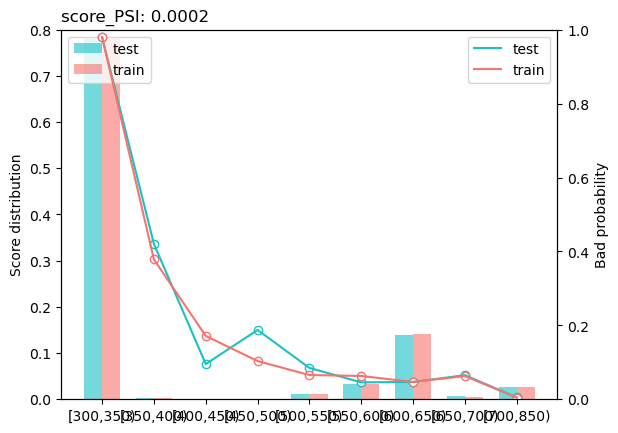

{'psi':   variable       PSI
 0    score  0.000175,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [ ]:
# logistic regression ------
lr = LogisticRegression(penalty='l1ß', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# score ------
card = sc.scorecard(bins, lr, X_train.columns)

# credit score
train_score = sc.scorecard_ply(train, card, print_step=0).clip(300, 850)
test_score = sc.scorecard_ply(test, card, print_step=0).clip(300, 850)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [335]:
train["b_score"] = train_score["score"].clip(300, 850)
test["b_score"]  = test_score["score"].clip(300, 850)

df_with_score = pd.concat([train, test]).sort_index() 
df_with_score.head()

,total_transactions,total_amount,avg_transaction_amount,max_transaction_amount,min_transaction_amount,unique_merchants,unique_banks,fraud_transaction_count,total_devices,transaction_is_fraud_flag,b_score
0,72,352197.44,4891.631111,9787.61,707.20,18,0,4,4,1,300.0
1,105,473650.55,4510.957619,9951.57,32.71,21,0,0,5,1,300.0
2,120,599040.78,4992.006500,9863.45,2058.64,20,1,12,6,1,300.0
3,48,215105.30,4481.360417,9709.38,312.60,24,1,8,2,1,300.0
4,42,207242.94,4934.355714,9084.11,546.76,21,1,6,2,1,300.0


In [336]:
df_copy["b_score"] = df_with_score["b_score"]
df_copy.head()

,user_id,name,email,phone,registration_date,job_title,user_type,kyc_status,is_fraud,total_transactions,total_amount,avg_transaction_amount,max_transaction_amount,min_transaction_amount,unique_merchants,unique_banks,fraud_transaction_count,total_devices,unique_ip_count,emulator_device_count,proxy_ip_count,alert_count,avg_alert_score,compliance_record_count,transaction_is_fraud_flag,b_score
0,0000c486-5511-4162-a780-9a80caa48b33,Cahyo Suryatmi,user66193@example.com,081200066193,2025-03-25 00:53:53.517312,Television floor manager,low_risk,rejected,False,72,352197.44,4891.631111,9787.61,707.20,18,0,4,4,0,0,0,0,None,0,1,300.0
1,00010207-c300-41d4-904f-bf62d1aad571,Sutan Kawaya Prasetya,user49343@example.com,081200049343,2022-01-13 08:42:54.595672,Clinical embryologist,normal,pending,False,105,473650.55,4510.957619,9951.57,32.71,21,0,0,5,0,21,0,0,None,0,1,300.0
2,00019313-37e4-4508-b60c-f09986b17591,H. Lurhur Purwanti,user32654@example.com,081200032654,2024-04-03 17:50:12.103058,Futures trader,low_risk,pending,False,120,599040.78,4992.006500,9863.45,2058.64,20,1,12,6,0,0,0,0,None,0,1,300.0
3,0001bb8f-3204-48d1-a35e-a2b9225c169c,Sabrina Widiastuti,user48554@example.com,081200048554,2020-05-28 18:56:50.365976,Arboriculturist,normal,pending,False,48,215105.30,4481.360417,9709.38,312.60,24,1,8,2,0,0,0,0,None,0,1,300.0
4,00026395-f892-4a4c-baa8-d9441f1d1dd7,"H. Darmanto Wahyudin, M.TI.",user93751@example.com,081200093751,2023-07-15 02:35:41.301018,"Investment banker, corporate",normal,rejected,False,42,207242.94,4934.355714,9084.11,546.76,21,1,6,2,0,21,0,0,None,0,1,300.0


In [342]:
df_copy.to_csv("hacketon_fraud_bscore_result.csv", index=False)

## Using different models for Credit Risk Analysis

In [338]:
# # Split the dataset
# X = df.drop(columns=['job_title'])  # drop identifiers and label
# y = df['transaction_is_fraud_flag']
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)

# # Train a model
# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]  # probability of fraud
# print(classification_report(y_test, y_pred))
# print("AUC Score:", roc_auc_score(y_test, y_prob))

In [339]:
# evaluation function
def evaluation(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("="*50)
    
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("Accuracy of TRAIN data:", 100*accuracy_score(y_train, y_train_pred))
    print("F1_Score of TRAIN data:", 100*f1_score(y_train, y_train_pred, average="macro"))
    print("="*50)
    
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    print("Accuracy of TEST data:", 100*accuracy_score(y_test, y_test_pred))
    print("F1_Score of TEST data:", 100*f1_score(y_test, y_test_pred, average="macro"))
    print("="*50)
    
    # calculate the RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("RMSE: ", rmse)
    
    # calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_test_pred, average=None)
    print("ROC AUC score: ", roc_auc)
    

In [340]:
# initialize LogisticRegression and fit the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# prediction
evaluation(logreg)

[[14614  1167]
 [  702 53517]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     15781
           1       0.98      0.99      0.98     54219

    accuracy                           0.97     70000
   macro avg       0.97      0.96      0.96     70000
weighted avg       0.97      0.97      0.97     70000

Accuracy of TRAIN data: 97.33000000000001
F1_Score of TRAIN data: 96.13678388402872
[[ 6249   514]
 [  290 22947]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      6763
           1       0.98      0.99      0.98     23237

    accuracy                           0.97     30000
   macro avg       0.97      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000

Accuracy of TEST data: 97.32
F1_Score of TEST data: 96.11704748868308
RMSE:  0.163707055437449
ROC AUC score:  0.9557590646207614


In [341]:
# y_prob = model.predict_proba(X_test)[:, 1]
# b_score = 300 + (1 - y_prob) * 550
# X_test['b_score'] = b_score.round(0).astype(int)